# Analyzing the WaterLLMarks results

In [479]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots


pd.options.mode.copy_on_write = True
renames = {
    "bleu_score": "BLEU",
    "rouge_score": "ROUGE-L",
    "meta_meteor_score": "METEOR",
    "non_llm_string_similarity": "Levenshtein Distance",
    "semantic_similarity": "Semantic Similarity",
    "factual_correctness": "Factual Correctness",
    "llm_context_precision_without_reference": "Context Precision",
    "context_recall": "Context Recall",
    "faithfulness": "Faithfulness",
    "context_overlap": "Context Overlap",
    "retrieved_context_similarity": "Context Similarity",
}

## Watermarks

In [480]:
from waterllmarks.datasets import LLMPaperDataset

ds = LLMPaperDataset()
questions = [qa["user_input"] for qa in ds.qas]
questions[0]


"Does the Turing Test assess a machine's ability to exhibit intelligent behavior equivalent to that of a human?"

In [481]:
from waterllmarks.watermarks import TokenWatermark, Rizzo2016, TextTooShortError

key = b"0123456789ABCDEF"

token_wmk = TokenWatermark(key)
rizzo_wmk = Rizzo2016(key)

lens = []
for q in questions:
    try:
        lens.append(
            {
                "raw": len(q.encode("utf-8")),
                "token": len(token_wmk.apply(q).encode("utf-8")),
                "rizzo": len(rizzo_wmk.apply(q).encode("utf-8")),
            }
        )
    except TextTooShortError:
        pass

df = pd.DataFrame(lens)
df

# Calculate overhead ratios
df["token_overhead_ratio"] = df["token"] / df["raw"]
df["rizzo_overhead_ratio"] = df["rizzo"] / df["raw"]

# Calculate absolute overhead
df["token_overhead"] = df["token"] - df["raw"]
df["rizzo_overhead"] = df["rizzo"] - df["raw"]


df.describe()


,raw,token,rizzo,token_overhead_ratio,rizzo_overhead_ratio,token_overhead,rizzo_overhead
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.0,162.000000
mean,128.000000,146.000000,173.043210,1.145216,1.362715,18.0,45.043210
std,24.528346,24.528346,25.416127,0.024855,0.070738,0.0,5.163595
min,87.000000,105.000000,132.000000,1.074689,1.171429,18.0,32.000000
25%,110.000000,128.000000,154.000000,1.128571,1.308783,18.0,42.000000
50%,123.000000,141.000000,169.000000,1.146341,1.366859,18.0,46.000000
75%,140.000000,158.000000,187.750000,1.163636,1.406936,18.0,48.000000
max,241.000000,259.000000,289.000000,1.206897,1.528736,18.0,60.000000


## LLM Performance

In [482]:
SETTINGS = {
    "seed": 1977,  # seed on which the experiment was run
    "n": 100,  # number of samples
    "dataset": "llm-papers",  # dataset name
    "model": "mistralai/Mistral-7B-Instruct-v0.3",
    "embedding": "intfloat/e5-mistral-7b-instruct",
}

### Evaluating the baseline

In [483]:
RESULTS_FILE = f"results/{SETTINGS['seed']}_baseline_results_noempty.pkl"


In [484]:
from waterllmarks.evaluation import WLLMKResult

results = WLLMKResult.load(RESULTS_FILE)


In [485]:
df = results.details.drop(
    columns=[
        "user_input",
        "retrieved_contexts",
        "reference_contexts",
        "response",
        "reference",
    ]
).rename(columns=renames)
df.describe()

,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity
count,520.000000,520.000000,520.000000,520.000000,520.000000,494.000000,511.000000,500.000000,503.000000,520.000000,520.000000
mean,0.110604,0.236649,0.317911,0.250960,0.760885,0.530830,0.882148,0.678081,0.785415,0.066827,0.740644
std,0.146359,0.176455,0.206977,0.149442,0.114318,0.370991,0.262476,0.426522,0.318549,0.110745,0.041753
min,0.000000,0.000000,0.000000,0.000000,0.360378,0.000000,0.000000,0.000000,0.000000,0.000000,0.631106
25%,0.021458,0.125000,0.178431,0.165159,0.684949,0.147500,0.916667,0.250000,0.666667,0.000000,0.713409
50%,0.054469,0.200000,0.290299,0.250816,0.770579,0.600000,1.000000,1.000000,1.000000,0.000000,0.738781
75%,0.146258,0.300472,0.424709,0.305104,0.844536,0.860000,1.000000,1.000000,1.000000,0.250000,0.763146
max,1.000000,1.000000,0.999938,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.250000,0.893919


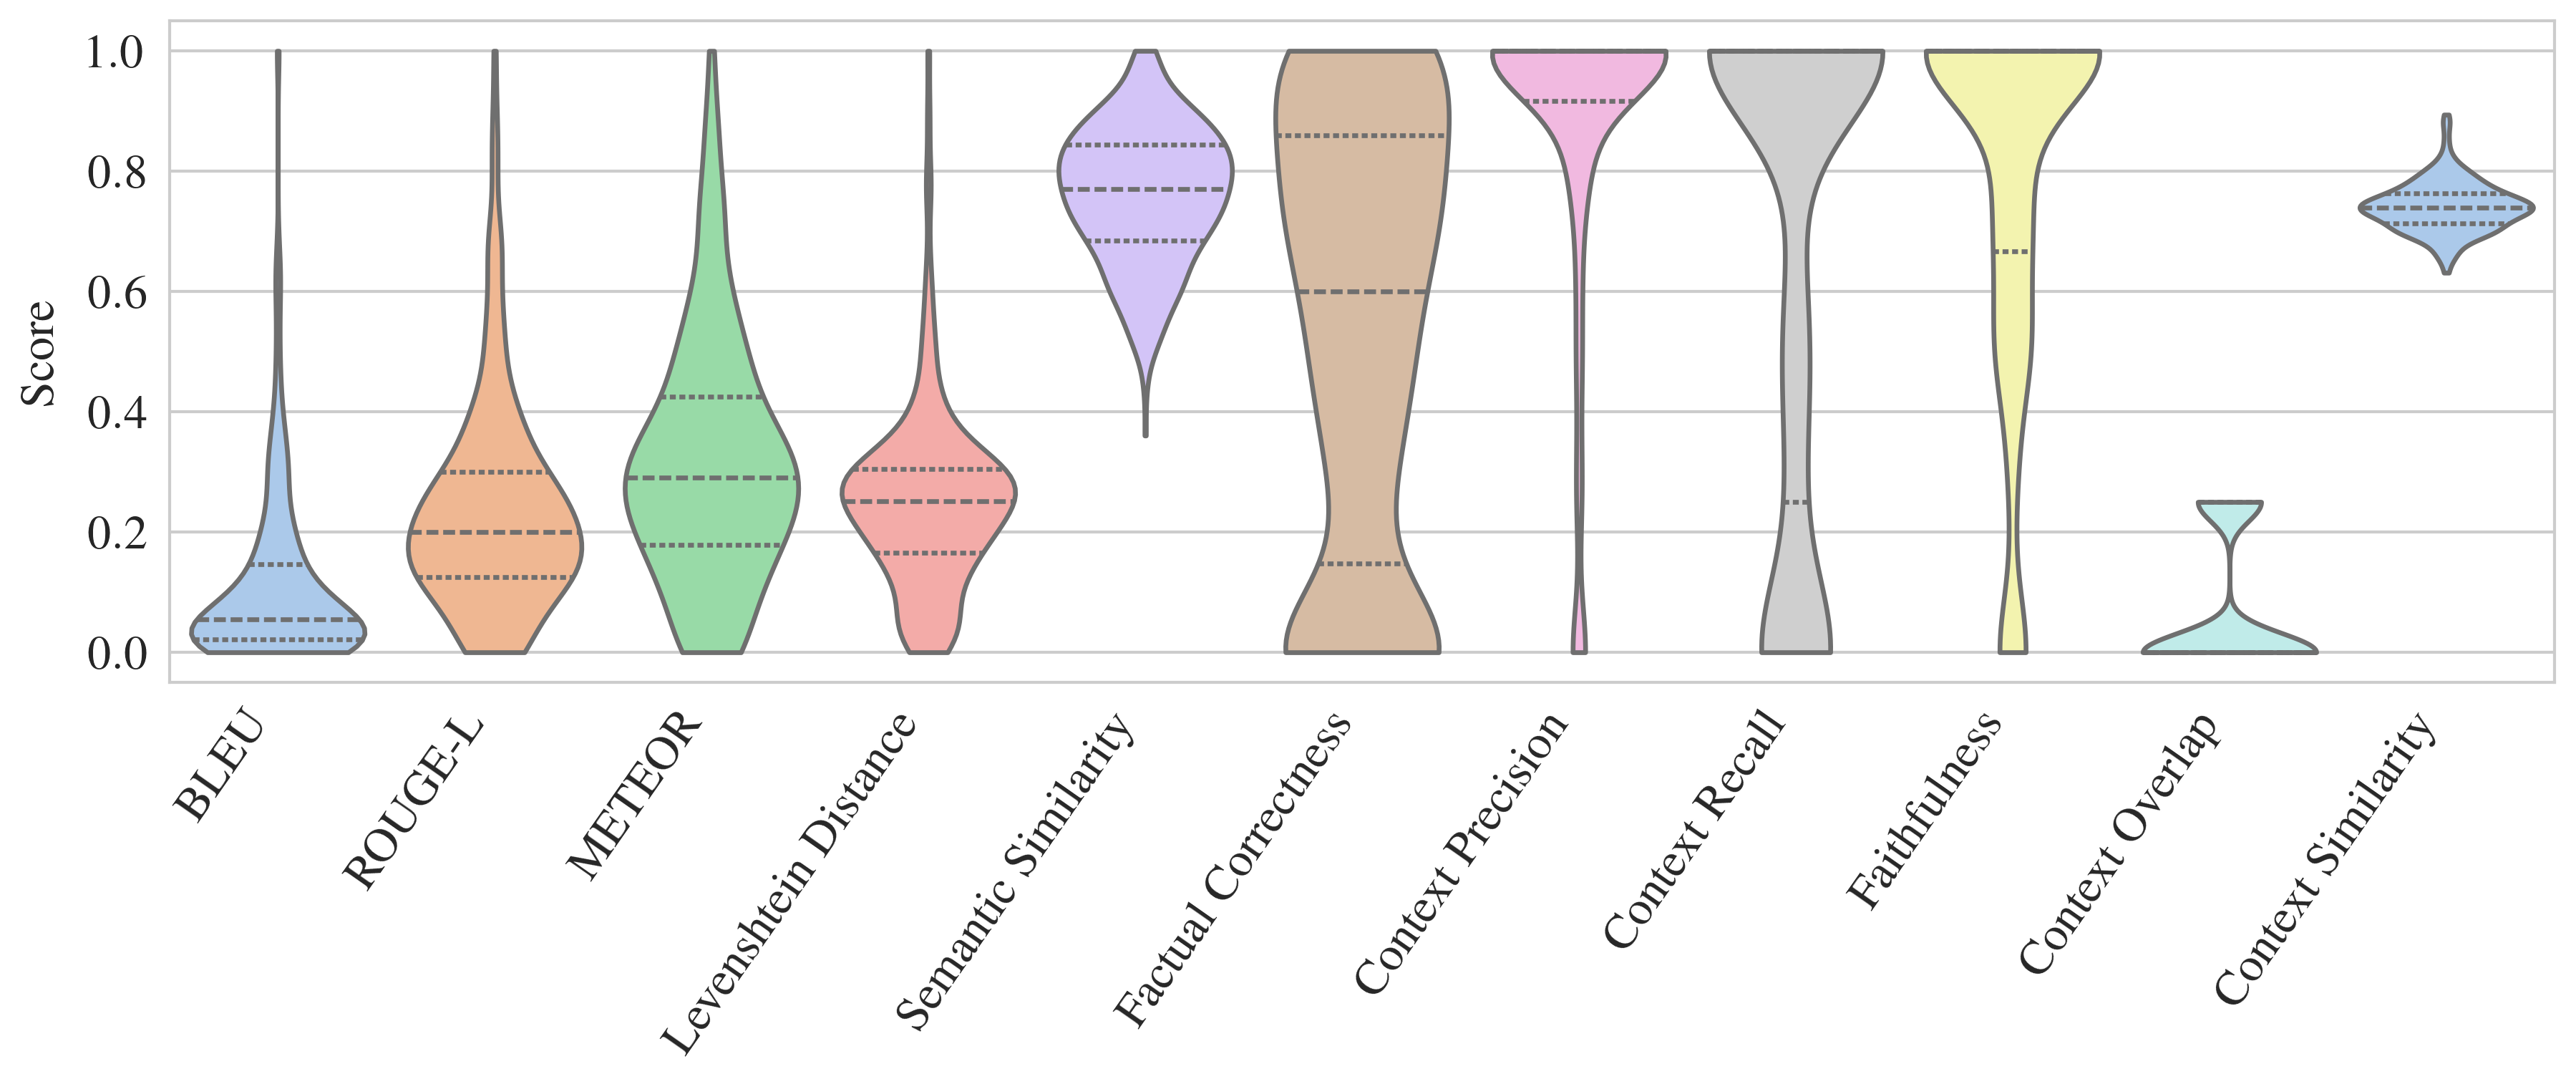

In [486]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid")
with plt.style.context(["science", "ieee"]):
    plt.rcParams["xtick.labelsize"] = 8
    plt.rcParams["ytick.labelsize"] = 8
    plt.rcParams["axes.labelsize"] = 8
    fig = plt.figure(figsize=(7.167, 2))
    sns.violinplot(
        data=df,
        cut=0,
        density_norm="count",
        palette="pastel",
        inner="quart",
        linewidth=0.8,
    )
    plt.xticks(rotation=55, ha="right")
    plt.tick_params(axis="both", which="both", length=0)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("Score")
    plt.show()

    fig.savefig("baseline_violin.pdf", bbox_inches="tight")


### Watermarks

In [487]:
RESULTS_FILE = f"results/{SETTINGS['seed']}_wllmk_results.pkl"
results = WLLMKResult.load(RESULTS_FILE)
results.details["integrated"] = results.details["embed"]
del results.details["embed"]

In [488]:
import pandas as pd

df = pd.DataFrame()
for k, v in results.details.items():
    tdf = v.drop(
        columns=[
            "user_input",
            "retrieved_contexts",
            "reference_contexts",
            "response",
            "reference",
        ]
    )
    tdf["qidx"] = tdf.index
    tdf["exp"] = k
    df = pd.concat([df, tdf], ignore_index=True)

df = df.rename(columns=renames)
df


,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity,qidx,exp
0,1.000000,0.629630,0.402000,0.521839,0.911981,1.00,0.000000,0.000000,0.00,0.142857,0.650391,0,token
1,0.111244,0.291667,0.400370,0.264605,0.759346,0.40,0.000000,1.000000,0.00,0.142857,0.716654,1,token
2,0.866398,0.894737,0.946719,0.960317,0.934570,0.75,1.000000,1.000000,1.00,0.600000,0.787445,2,token
3,0.320054,0.312500,0.233638,0.346614,0.888850,0.00,1.000000,0.000000,0.60,0.142857,0.769618,3,token
4,0.450984,0.285714,0.284944,0.410526,0.858720,0.73,0.833333,0.333333,0.80,0.000000,0.698362,4,token
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.123750,0.225352,0.234781,0.360092,0.790045,0.00,1.000000,1.000000,1.00,0.142857,0.742482,514,integrated
1034,0.251962,0.238095,0.204201,0.319728,0.782727,0.00,1.000000,1.000000,1.00,0.142857,0.685316,515,integrated
1035,0.001395,0.105727,0.089606,0.113699,0.555043,0.00,1.000000,1.000000,0.00,0.000000,0.652024,516,integrated
1036,0.156127,0.269231,0.227370,0.306785,0.701592,0.33,0.805556,1.000000,0.25,0.142857,0.686033,517,integrated


In [489]:
results.details["token"].drop(
    columns=[
        "user_input",
        "retrieved_contexts",
        "reference_contexts",
        "response",
        "reference",
    ]
).rename(columns=renames).describe()

,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity
count,519.000000,519.000000,519.000000,519.000000,519.000000,484.000000,515.000000,500.000000,506.000000,519.000000,519.000000
mean,0.453847,0.485661,0.500450,0.474112,0.884936,0.590248,0.870065,0.815762,0.788592,0.367593,0.739676
std,0.311400,0.246298,0.246334,0.228270,0.096992,0.341457,0.280901,0.320771,0.326769,0.256721,0.042541
min,0.000000,0.000000,0.000000,0.000000,0.504323,0.000000,0.000000,0.000000,0.000000,0.000000,0.636620
25%,0.200007,0.296586,0.320999,0.317490,0.834289,0.360000,0.916667,0.666667,0.666667,0.142857,0.711503
50%,0.393022,0.436364,0.455184,0.414798,0.911638,0.670000,1.000000,1.000000,1.000000,0.333333,0.738441
75%,0.697817,0.630604,0.652572,0.569599,0.954577,0.890000,1.000000,1.000000,1.000000,0.600000,0.763781
max,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.890908


In [490]:
results.details["integrated"].drop(
    columns=[
        "user_input",
        "retrieved_contexts",
        "reference_contexts",
        "response",
        "reference",
    ]
).rename(columns=renames).describe()

,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity
count,519.000000,519.000000,519.000000,519.000000,519.000000,473.000000,512.000000,489.000000,512.000000,519.000000,519.000000
mean,0.209238,0.306499,0.348447,0.320105,0.818746,0.474313,0.850586,0.735750,0.694046,0.150087,0.718541
std,0.205755,0.170841,0.185756,0.136687,0.101681,0.327239,0.294979,0.383724,0.363036,0.176303,0.048369
min,0.000000,0.000000,0.000000,0.003846,0.453029,0.000000,0.000000,0.000000,0.000000,0.000000,0.584991
25%,0.053921,0.197175,0.225960,0.248894,0.750486,0.200000,0.833333,0.500000,0.500000,0.000000,0.686898
50%,0.128659,0.269231,0.304889,0.300000,0.838446,0.500000,1.000000,1.000000,0.833333,0.142857,0.716355
75%,0.312154,0.380617,0.432072,0.365566,0.893366,0.750000,1.000000,1.000000,1.000000,0.333333,0.744998
max,1.000000,0.971429,0.991460,0.932773,0.992965,1.000000,1.000000,1.000000,1.000000,1.000000,0.891661


In [491]:
# Calculate the mean for each metric and technique
mean_token = (
    results.details["token"]
    .drop(
        columns=[
            "user_input",
            "retrieved_contexts",
            "reference_contexts",
            "response",
            "reference",
        ]
    )
    .rename(columns=renames)
    .mean()
)

mean_integrated = (
    results.details["integrated"]
    .drop(
        columns=[
            "user_input",
            "retrieved_contexts",
            "reference_contexts",
            "response",
            "reference",
        ]
    )
    .rename(columns=renames)
    .mean()
)

# Calculate the delta between the means
delta = mean_token - mean_integrated

# Calculate the average delta
delta.mean(), delta.std()

(0.12223476672926493, 0.07463136213778698)

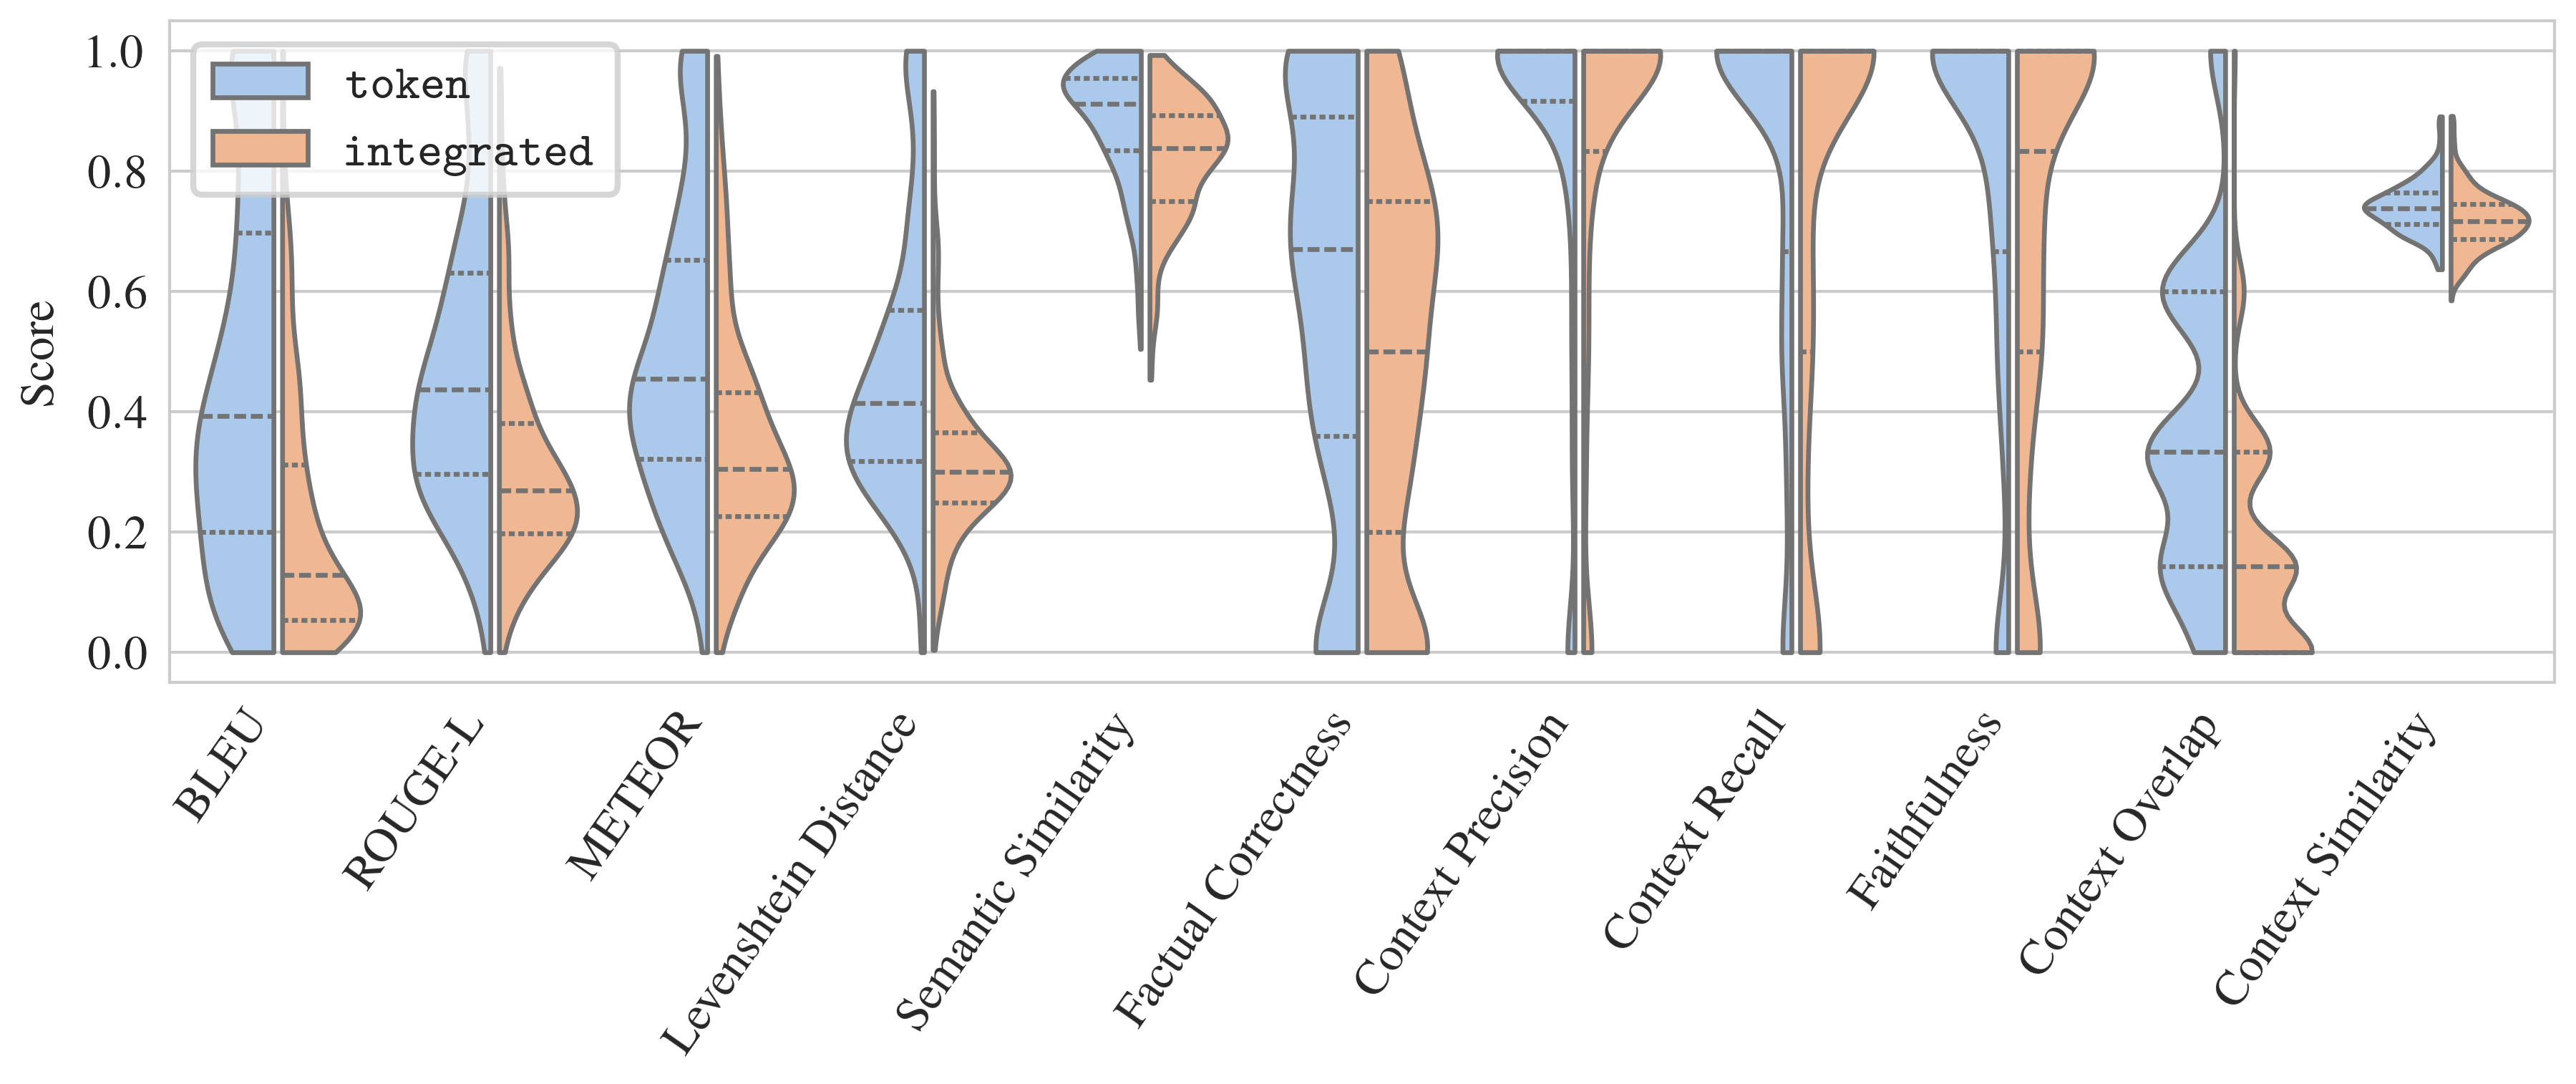

In [492]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")
data = df.melt(id_vars=["exp", "qidx"], var_name="metric", value_name="score")
with plt.style.context(["science", "ieee"]):
    plt.rcParams["xtick.labelsize"] = 8
    plt.rcParams["ytick.labelsize"] = 8
    plt.rcParams["axes.labelsize"] = 8
    plt.rcParams["legend.fontsize"] = 8
    fig = plt.figure(figsize=(7.167, 2))
    sns.violinplot(
        data=data,
        x="metric",
        y="score",
        split=True,
        hue="exp",
        cut=0,
        gap=0.1,
        inner="quartile",
        density_norm="count",
        palette="pastel",
        linewidth=0.8,
    )
    # ax = plt.gca()
    # for l in ax.lines:
    #     ax.text(
    #         l.get_data()[0][l.get_data()[0].nonzero()][0],
    #         l.get_data()[1][0],
    #         f"{l.get_data()[1][0]:.2f}",
    #         size=6,
    #     )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        frameon=True,
        handles=handles,
        labels=[rf"\texttt{{{l}}}" for l in labels],
        loc="upper left",
    )
    plt.xticks(rotation=55, ha="right")
    plt.tick_params(axis="both", which="both", length=0)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("Score")
    plt.show()

    fig.savefig("watermark_violin.pdf", bbox_inches="tight")

### Augmented prompts vs. original

In [493]:
RESULTS_FILE = f"results/{SETTINGS['seed']}_augmented_results.pkl"
results = WLLMKResult.load(RESULTS_FILE)

In [494]:
import pandas as pd

df = pd.DataFrame()
for k, v in results.details.items():
    tdf = v.drop(
        columns=[
            "user_input",
            "retrieved_contexts",
            "reference_contexts",
            "response",
            "reference",
        ]
    )
    tdf["qidx"] = tdf.index
    tdf["exp"] = k
    df = pd.concat([df, tdf], ignore_index=True)

df = df.rename(columns=renames)
df


,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity,qidx,exp
0,0.000000,0.000000,0.000000,0.005333,0.360378,0.00,1.000000,1.0,0.666667,0.0,0.657919,0,baseline
1,0.621972,0.780488,0.781257,0.775194,0.951430,0.75,1.000000,1.0,1.000000,0.0,0.788591,2,baseline
2,0.343893,0.700000,0.747174,0.650794,0.895121,0.00,0.638889,1.0,0.000000,0.0,0.709596,4,baseline
3,0.019853,0.150000,0.147059,0.189286,0.729099,0.00,1.000000,1.0,0.800000,0.0,0.685867,5,baseline
4,0.024427,0.148148,0.311423,0.219081,0.828988,NaN,1.000000,1.0,1.000000,0.0,0.717082,7,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.032342,0.102190,0.134875,0.247649,0.593588,0.40,1.000000,0.0,0.428571,0.0,0.747547,352,augmented
710,0.002636,0.056338,0.042735,0.196581,0.553615,0.00,0.750000,0.0,0.000000,0.0,0.706815,353,augmented
711,0.000000,0.042553,0.060606,0.232198,0.562109,0.00,0.916667,0.0,0.000000,0.0,0.728312,354,augmented
712,0.015394,0.142857,0.179104,0.205556,0.579088,0.86,0.805556,0.0,1.000000,0.0,0.718475,355,augmented


In [495]:
results.details["augmented"].drop(
    columns=[
        "user_input",
        "retrieved_contexts",
        "reference_contexts",
        "response",
        "reference",
    ]
).rename(columns=renames).describe()

,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity
count,357.000000,357.000000,357.000000,357.000000,357.000000,338.000000,355.000000,345.000000,349.000000,357.000000,357.000000
mean,0.015783,0.074993,0.106471,0.166407,0.561388,0.278787,0.868779,0.145836,0.728232,0.000700,0.731044
std,0.012671,0.053084,0.069023,0.086897,0.072895,0.349136,0.282473,0.315872,0.350543,0.013231,0.049490
min,0.000000,0.000000,0.000000,0.000000,0.346355,0.000000,0.000000,0.000000,0.000000,0.000000,0.583217
25%,0.006156,0.028269,0.053381,0.096386,0.509366,0.000000,0.916667,0.000000,0.500000,0.000000,0.701882
50%,0.015458,0.080000,0.108696,0.190647,0.559879,0.000000,1.000000,0.000000,1.000000,0.000000,0.732153
75%,0.021671,0.111111,0.151976,0.242894,0.609056,0.550000,1.000000,0.000000,1.000000,0.000000,0.761449
max,0.068372,0.238806,0.372714,0.299213,0.762037,1.000000,1.000000,1.000000,1.000000,0.250000,0.907724


In [496]:
results.details["baseline"].drop(
    columns=[
        "user_input",
        "retrieved_contexts",
        "reference_contexts",
        "response",
        "reference",
    ]
).rename(columns=renames).describe()


,BLEU,ROUGE-L,METEOR,Levenshtein Distance,Semantic Similarity,Factual Correctness,Context Precision,Context Recall,Faithfulness,Context Overlap,Context Similarity
count,357.000000,357.000000,357.000000,357.000000,357.000000,335.000000,349.000000,344.000000,344.000000,357.000000,357.000000
mean,0.119863,0.248121,0.334363,0.257913,0.767473,0.539403,0.888889,0.696968,0.791642,0.072829,0.739267
std,0.154441,0.186369,0.217226,0.154347,0.114627,0.366873,0.255083,0.418283,0.317593,0.113752,0.040930
min,0.000000,0.000000,0.000000,0.000000,0.360378,0.000000,0.000000,0.000000,0.000000,0.000000,0.631106
25%,0.022870,0.126582,0.189474,0.166094,0.694513,0.220000,0.916667,0.333333,0.666667,0.000000,0.712590
50%,0.063137,0.210526,0.304670,0.255725,0.778397,0.620000,1.000000,1.000000,1.000000,0.000000,0.737618
75%,0.163073,0.313725,0.449550,0.314286,0.848282,0.860000,1.000000,1.000000,1.000000,0.250000,0.763633
max,1.000000,1.000000,0.999938,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.250000,0.893919


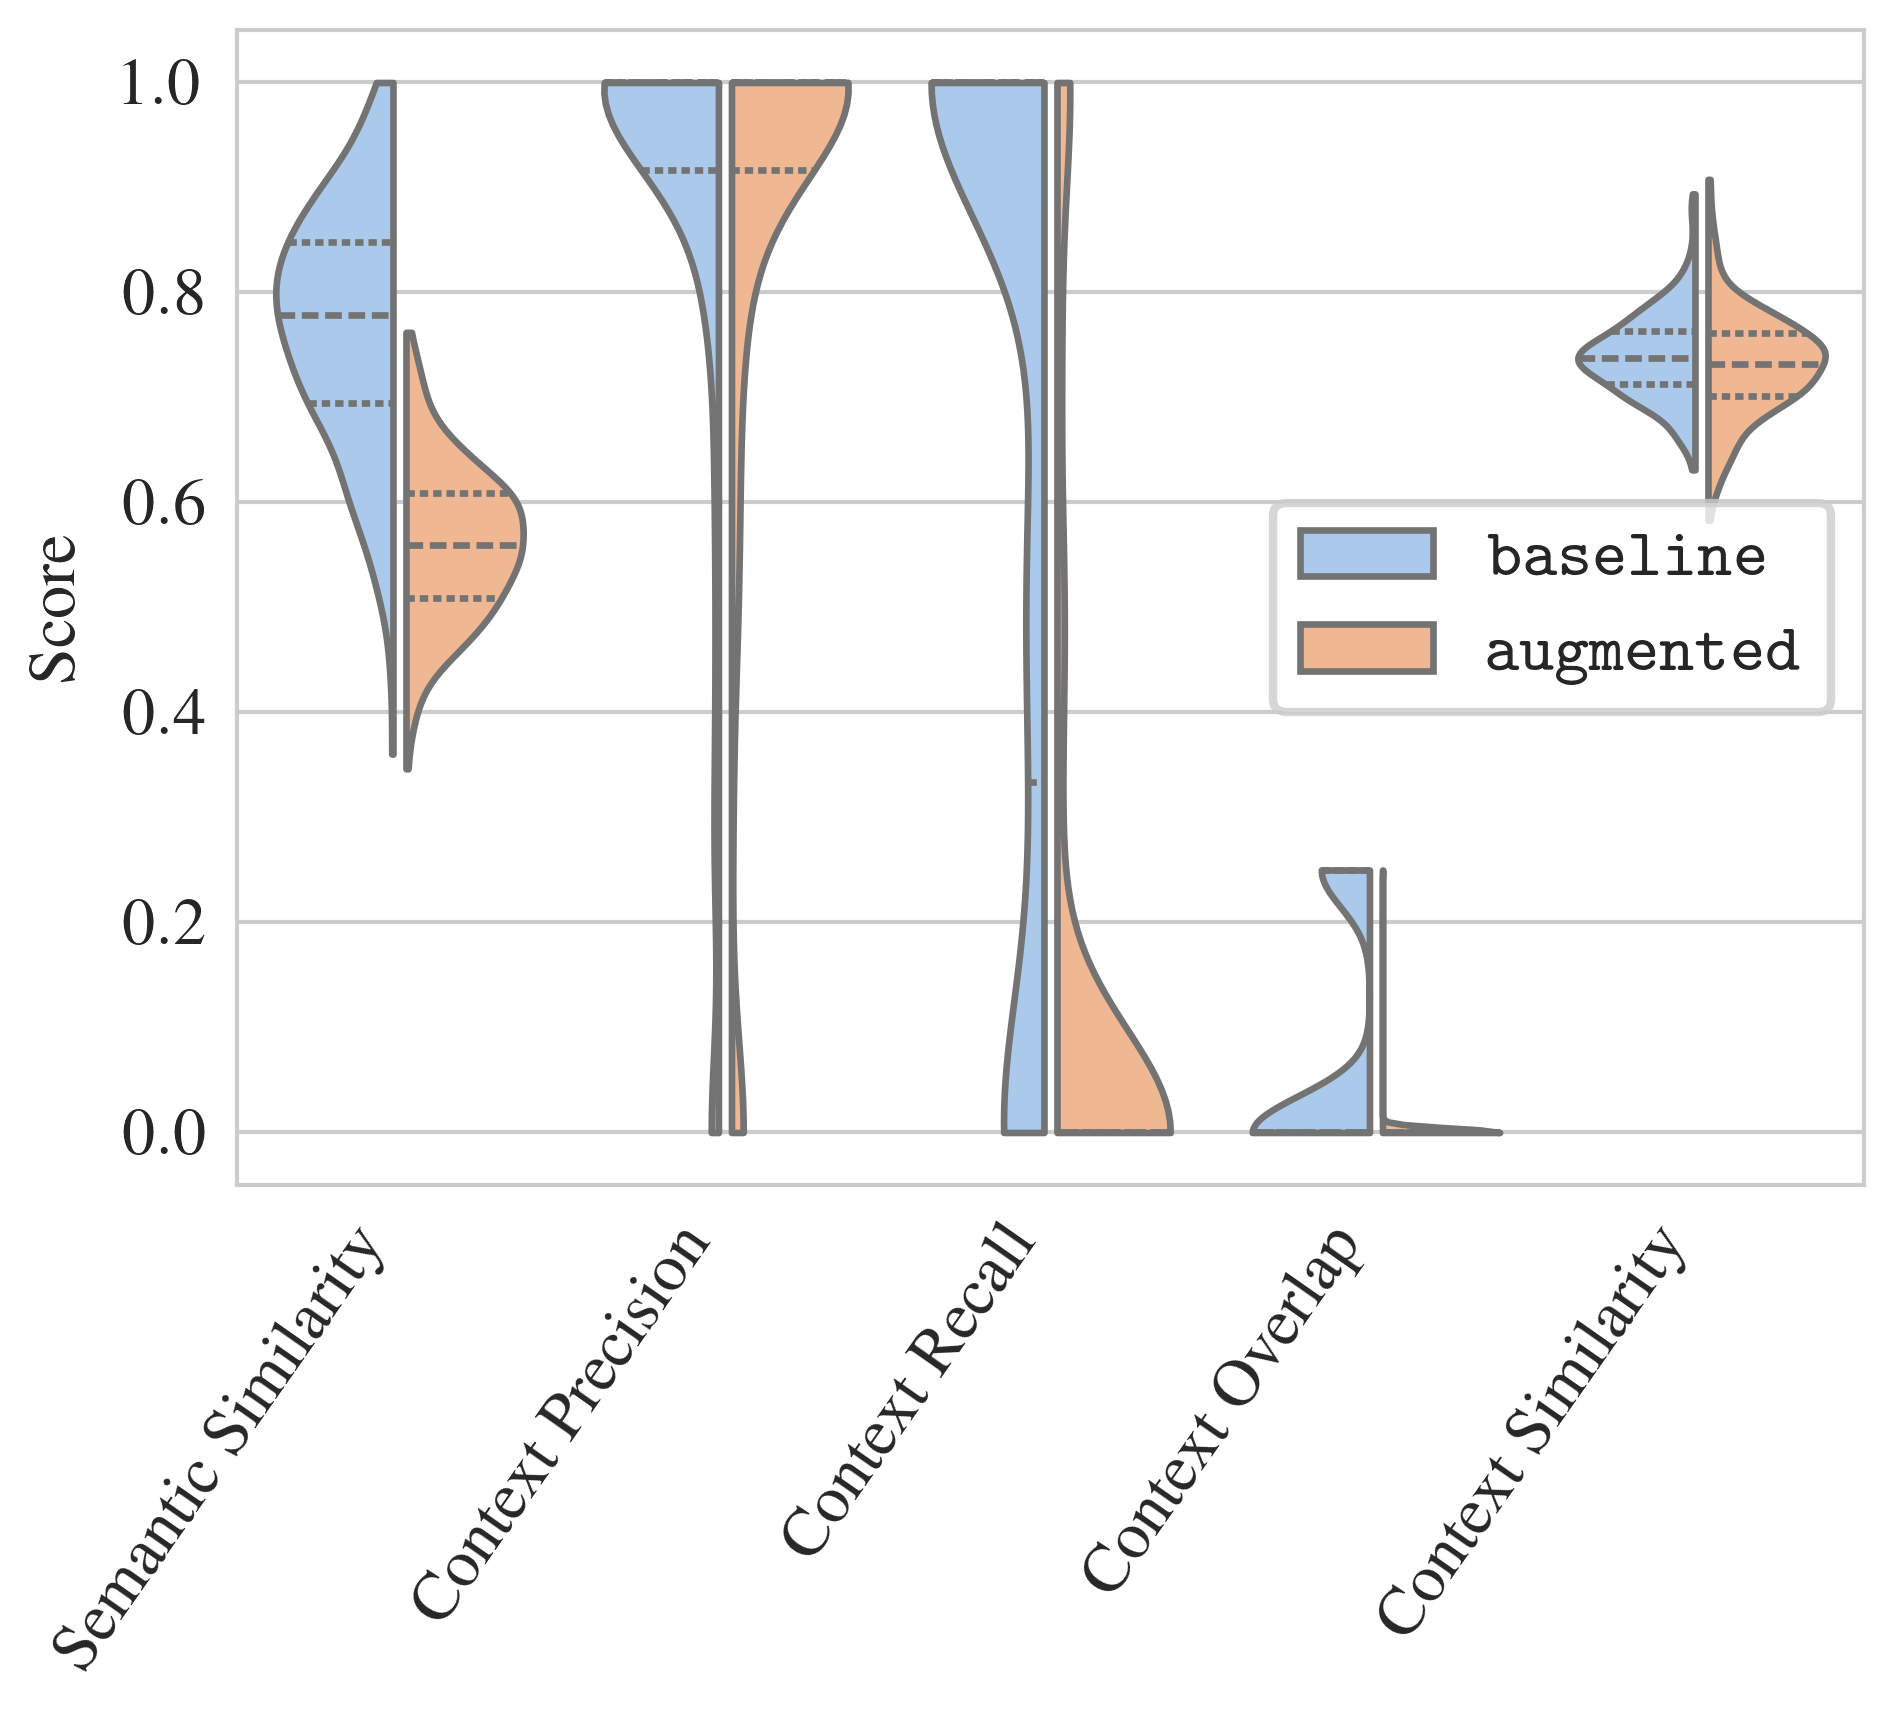

In [497]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")
data = df.drop(
    columns=[
        "BLEU",
        "ROUGE-L",
        "METEOR",
        "Levenshtein Distance",
        "Factual Correctness",
        "Faithfulness",
    ]
).melt(id_vars=["exp", "qidx"], var_name="metric", value_name="score")
with plt.style.context(["science", "ieee"]):
    plt.rcParams["xtick.labelsize"] = 8
    plt.rcParams["ytick.labelsize"] = 8
    plt.rcParams["axes.labelsize"] = 8
    plt.rcParams["legend.fontsize"] = 8

    fig = plt.figure(figsize=(3.5, 2.5))
    sns.violinplot(
        data=data,
        x="metric",
        y="score",
        split=True,
        hue="exp",
        cut=0,
        gap=0.1,
        inner="quartile",
        density_norm="count",
        palette="pastel",
        linewidth=0.8,
    )
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        frameon=True,
        handles=handles,
        labels=[rf"\texttt{{{l}}}" for l in labels],
    )
    plt.xticks(rotation=55, ha="right")
    plt.tick_params(axis="both", which="both", length=0)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("Score")
    plt.show()

    fig.savefig("augment_violin.pdf", bbox_inches="tight")